In [4]:
import csv
from enum import Enum
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
import time

# import my own libraries
from sim_loop import *          # import the simulator loop 
from drawRobot import *         # import code that plots the vehicle and arm extension
# from arm import *               # import the arm state library
# from camera import *            # import the simulated vision system
# from fruitTreeCreator import *  # import the library that creates the array with fruit location + other info
# from scheduler import *         # import the scheduler functions 
# from simulation_config import * # import the JSON creation file so that it can be read back to set parameters
# from trajectory import *        # import the trajectory generation "library" that I'm writing

import json # configuration file encode and decode
# see https://realpython.com/python-json/#decoding-custom-types

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [5]:
######## RANDOM SEED GENERATOR ########
'''Use only when a new seed is needed'''
# https://numpy.org/devdocs/reference/random/index.html

# from numpy.random import PCG64, SeedSequence

# sq1 = np.random.SeedSequence()

# seed = sq1.entropy

# print(seed)

### How to use seeds
## ss = SeedSequence(seed)
## print('seed = {}'.format(ss.entropy))
## bg = PCG64(ss)

######### GENERATED SEEDS ##########
## FRUIT TREE CREATOR SEEDS ##
# self.x_fr - 37428395352013185889194479428694397783 
# self.y_fr - 13250124924871709375127216220749555998
# self.z_fr - 165440185943501291848242755689690423219
# self.x_fake - 264090507119924891834746017829286837587
# self.y_fake - 307175982666302731017951161793326853810
# self.z_fake - 202459549346992037879433717317760015805


'Use only when a new seed is needed'

In [6]:
def step(t, dt):
    t = t + dt
    return t

In [7]:
# class drawRobot(object):
#     def __init__(self):
#         self.a = 0
        
#     def drawRect(self, q_curr, width_v, length_v):

#         xl  = q_curr[0] + width_v / 2  # left x coordinate
#         xr  = q_curr[0] - width_v / 2  # right x coordinate

#         yf  = q_curr[1] - length_v / 2 # front
#         yb  = q_curr[1] + length_v / 2 # back

#         verts = []

#         xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
#         ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
#         z_axis = [0, 0, 0, 0, 0]

#         verts = [list(zip(xs, ys, z_axis))]

#         poly = Poly3DCollection(verts, facecolors="blue", closed = False)
#         ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
#     def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
#         xl  = left_edge  # back x coordinate
        
#         yf  = front_edge # front y coordinate
#         yb  = back_edge  # back y coordinate

#         zt  = z_edges_f[0]  # top z coordinate
#         zb  = z_edges_f[1]  # bottom z coordinate

#         verts = []
        
#         xs = [xl, xl, xl, xl, xl]
#         ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
#         z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
#         verts = [list(zip(xs, ys, z_axis))]
        
#         poly = Poly3DCollection(verts, closed = False, alpha=0.25)
#         poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
#         ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
#     def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
#         # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
#         radius = 0.2 # set arbitrarily 
        
#         x     = np.linspace(arm_start, arm_end, 3)
#         theta = np.linspace(0, 2*np.pi, 3)
        
#         theta_grid, x_grid = np.meshgrid(theta, x)
        
#         y_grid = radius*np.cos(theta_grid) + center_y
#         z_grid = radius*np.sin(theta_grid) + center_z
        
#         return x_grid,y_grid,z_grid
            

In [8]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [9]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [10]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1
    
    
class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    DENSITY   = 1

In [11]:
###### create JSON configuration file to read from #####
# init function
json_data = simulation_config()

# creates the data file based on default values 
json_data.convertJSON()

# load the json file
data = json.load(open("data.json"))

###### Parameter settings from the JSON configuration file ######

# fruit row depth, in ft  -- x-axis
fruit_row_ed   = data['orchard']['x']['start']  # how far the vehicle will be from the edges of the tree
fruit_row_tk   = data['orchard']['x']['end']    # how far the arms can reach into the canopy/ where the trunk is

# fruit row length, in ft -- y-axis
fruit_row_st   = data['orchard']['y']['start']  
fruit_row_end  = data['orchard']['y']['end'] 

# fruit row height, in ft -- z-axis
fruit_row_bt   = data['orchard']['z']['start']
fruit_row_tp   = data['orchard']['z']['end'] 

# values for fruit density (currently supports only one value overall)
rho_real       = data['orchard']['rho_real']
rho_fake       = data['orchard']['rho_fake']

# decide on the number of arms and rows
num_arms       = data['vehicle']['num_arms']      # set number of arms on robot, will determine the length of the robot (for now)
num_row        = data['vehicle']['num_rows']      # set the number of rows of arms 

# arm's max velocity and acceleration values apparently in ft/s
max_v          = data['arms']['max_v']
max_a          = data['arms']['max_a']

# vehicle's velocity (constant), in ft/s
v_vx           = data['vehicle']['v_vx'] 
v_vy           = data['vehicle']['v_vy']

# number of goals the semionline scheduler will look for
n_goals        = data['num_goals']                

# when working with the fruit ribbon, how high above the conveyors will the ribbon be
ribbon_z       = data['ribbon_z']

# decide if the arms are in individual or shared spaces
space_config   = spaceConf(data['space_config'])

# decide on the type of scheduler
appointment    = calendar(data['appointment'])

# decide what fruit distribution to use to create fruit coordinates
data_config    = treeCreation(data['data_config'])

# decide if fake fruit will be added
existance      = reality(data['existance'])

# decide if noise should be added and the distribution
noise_level    = noiseMaker(data['noise_level'])



Would you like to save the JSON configurations in seperate file? (y or n)n
File was not saved. Thank you for using our services!


In [12]:
####### Vehicle Init Values for parameter setting #######
# configure the vehicle

# create the vehicle speed array 
v_v = np.array([v_vx,v_vy])  # in ft, constant velocity only in y-axis

# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# calculate the height of the frame based on number of rows, height of orchard, and add column width to make sure all
# fruit can be reached
frame_height = (fruit_row_tp - fruit_row_bt + 2*column_width) / num_row # if the rows are evenly spaced

# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 3.
#     frame_width  = 1.9

width_v  = 1.                    # vehicle width (x-dir, parallel to arms going into canopy) (only for plotting)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

##################### Based on Flags #####################

# initializes required variables based on the distribution creation method
if data_config != treeCreation.CSV_RAJ: 
    q_v = np.array([fruit_row_ed-1.0/2-0.3, fruit_row_st]) 
    # init a z-coordinate list of where a fruit ribbon will be placed on each row
    fruit_lines = []
    # if using the line distribution, this will set the z height for each line
    for n in range(num_row):
        fruit_lines.append(n*frame_height + ribbon_z) # in ft
        
    # initialize the synthetic fruit distribution creator
    fruit = fruitTreeCreator([fruit_row_st,fruit_row_end]) 
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.
    # create list for fruit and fake fruit 
    fruit_density = []
    fake_density  = []
    
    for n in range(num_row):
        # set fruit density and percent of fake fruit to add (will have to change later to add sections
        # with different densities)
        fruit_density.append([rho_real])  # in fruit/ft^3 (unless using LINE, then it's fruit/ft^2)
        if existance == reality.DENSITY:
            fake_density.append([rho_fake])
        else:
            fake_density.append([0.0])

    
elif data_config == treeCreation.CSV_RAJ:
    q_v = np.array([4.5,7.]) # fruits are in very specific locations
    # CSV fruit are diagonally placed (fix that later?)
    v_v = np.array([0.01,0.05])  # in ft, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)
    # use Raj's digitized fruit from real trees
    fruit = csvRead()  
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.75 / (num_row-1)

    
    
if data_config == treeCreation.SYN_LINE:  
    # create synthetic fruit data in a line to test the robot when fruit are set at one specific height
    for r in range(num_row):
        fruit.fruitLine(num_row, fruit_density[r], [fruit_row_ed,fruit_row_tk], fruit_lines[r], fake_density[r])
#     fruit.fruitLine(fruit_lines)
    fruit.fruitTreeOut()
    
elif data_config == treeCreation.UNIFORM:
    # test the robot when there is variation in distance between fruit
#     fruit.fruitUniform()
    for r in range(num_row):
        fruit.fruitUniform(num_row,fruit_density[r],[fruit_row_ed,fruit_row_tk],[fruit_row_bt,fruit_row_tp], fake_density[r])
    fruit.fruitTreeOut()
        
    

In [13]:
####################### init vehicle lists for data analysis #######################
# used to plot the vehicle
qv0 = []
qv1 = []

##################### init environment #####################
# end of the row (when the back of vehicle reaches this point it should stop)
end_row = fruit_row_end + width_v
t       = []         # 'global' time
t_step  = 0.
dt      = 0.01      # 'global' time step size
runs    = 0

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object) 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location 
        
        # initialize the new arm
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)

        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

s = scheduler(n_goals, num_row, num_arms, max_v, max_a) 
# make a scheduler function that sets n_goals only if it's synthetic data

In [14]:
### MAIN LOOP CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit, t_step)
        
    elif appointment == calendar.EDF:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.edfScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step, fruit, row_picture)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].stateFLAG])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: -0.2 0.988814429908131 0.0
start, end, start velocity: 3.0 0.0015401856941155145 0.0
start, end, start velocity: 1.5666666666666667 0.6442726013808399 0.0
start, end, start velocity: 0.988814429908131 -0.2 0.0
start, end, start velocity: 0.6442726013808399 0.0 0.0
start, end, start velocity: -0.2 1.0705508498659766 0.0
start, end, start velocity: 0.0 0.07059252397484395 0.0
start, end, start velocity: 1.5666666666666667 1.448549770617991 0.0
start, end, start velocity: 1.0705508498659766 -0.2 0.0
start, end, start velocity: 1.448549770617991 0.0 0.0
start, end, start velocity: -0.2 0.7134600028870357 0.0
start, end, start velocity: -3.0 0.09347548702352548 0.0
start, end, start velocity: 1.5666666666666667 0.09331199847688876 0.0
start, end, start velocity: 0.7134600028870357 -0.2 0.0
start, end, start velocity: 0.09331199847688876 0.0 0.0
start, end, start velocity: -0.2 0.9275786991267165 0.0
start, end, start velocity: 0.0015401856941155145 0.363791579983

start, end, start velocity: -0.2 1.0466046638488198 0.0
start, end, start velocity: 3.0 0.7709214427451511 0.0
start, end, start velocity: 1.5666666666666667 1.8387775065352523 0.0
start, end, start velocity: -0.2 0.7034945713468113 0.0
start, end, start velocity: 3.0 0.6736073096466094 0.0
start, end, start velocity: 4.7 3.5287049370222485 0.0
start, end, start velocity: -0.2 0.3240905580098938 0.0
start, end, start velocity: 3.0 0.44506045419106244 0.0
start, end, start velocity: 7.833333333333333 8.344168791424288 0.0
*** No value came up, broke out of the if statement ***
start, end, start velocity: 0.5350000000000004 1.2477891983151859 0.0
start, end, start velocity: 0.10699126336567717 0.06349522470232849 0.0
start, end, start velocity: 4.763537989345128 5.7530461940647335 0.0
start, end, start velocity: 1.2477891983151859 0.5350000000000004 0.0
start, end, start velocity: 5.7530461940647335 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
start, end

start, end, start velocity: 0.8900481726854138 -0.2 0
start, end, start velocity: 1.281540629061688 -0.2 0
start, end, start velocity: 0.6420269559831765 -0.2 0
start, end, start velocity: 5.161964580874536 3.1333333333333337 0.0
start, end, start velocity: 2.3874646876619683 0.0 0.0
start, end, start velocity: 0.3416933367455999 -0.2 0
start, end, start velocity: 6.509887021745848 6.266666666666667 0.0
start, end, start velocity: 0.5439479680315177 0.0 0.0
start, end, start velocity: 5.714635330071302 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999991108 0.5686372041609955 0.0
start, end, start velocity: 0.8933395761140182 1.3302617006674622 0.0
start, end, start velocity: 6.266666666666709 8.10344319847326 0.0
start, end, start velocity: 0.7067181501611933 -0.2 0
start, end, start velocity: 7.663916059022049 6.266666666666667 0.0
start, end, start velocity: -0.19999999999987714 0.9867435513515699 0.0
start, end, start velocity: 1.7516502511420802 2.0293197344830647 

start, end, start velocity: 0.7565513884386524 -0.2 0
start, end, start velocity: 1.0604562585349628 -0.2 0
start, end, start velocity: 2.994122117109622 0.0 0.0
start, end, start velocity: -0.19999999999981627 1.2139785664412797 0.0
start, end, start velocity: 2.654153660713625 3.2699355993198926 0.0
start, end, start velocity: 6.266666666667009 7.464392826020619 0.0
start, end, start velocity: 0.5522786911476988 -0.2 0
start, end, start velocity: 0.5708056810239058 -0.2 0
start, end, start velocity: -0.1999999999998256 0.6130101636642282 0.0
start, end, start velocity: 1.8358368918771824 2.199283668451635 0.0
start, end, start velocity: 3.756709570160166e-13 2.36640431125884 0.0
start, end, start velocity: -0.1999999999998738 0.8588847505551449 0.0
start, end, start velocity: 1.3615089653013817 1.4830198266946704 0.0
start, end, start velocity: 3.133333333333714 5.419169273267413 0.0
start, end, start velocity: 8.843847931055915 6.266666666666667 0.0
start, end, start velocity: 1.008

start, end, start velocity: -0.2 0.8996579609066588 0.0
start, end, start velocity: 3.6162841484187997 4.072728772980927 0.0
start, end, start velocity: 5.0131989268240345 3.21942638400315 0.0
start, end, start velocity: 0.6147259496274144 -0.2 0
start, end, start velocity: 2.616268879028748 0.0 0.0
start, end, start velocity: -0.2 0.8806429695428113 0.0
start, end, start velocity: 3.8012841484187936 5.877296564887616 0.0
start, end, start velocity: 4.828198926824048 6.202756668531453 0.0
start, end, start velocity: 0.8806429695428113 -0.2 0.0
start, end, start velocity: 6.202756668531453 3.1333333333333337 0.0
start, end, start velocity: 0.13499999999998902 1.1043927242452316 0.0
start, end, start velocity: 3.4152841484187997 3.5308336408349876 0.0
start, end, start velocity: 4.066819088570369 5.0131989268237 0.0
start, end, start velocity: 1.1043927242452316 0.13499999999998902 0.0
start, end, start velocity: 5.0131989268237 3.1333333333333337 0.0
start, end, start velocity: 0.439725

start, end, start velocity: -0.2 0.4190996151313598 0.0
start, end, start velocity: 4.601656225795471 6.35020282650782 0.0
start, end, start velocity: 3.2983333333333205 4.08553668699943 0.0
start, end, start velocity: 0.4190996151313598 -0.2 0.0
start, end, start velocity: 4.08553668699943 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.5057984107758069 0.0
start, end, start velocity: 4.312217593465962 4.275297003763024 0.0
start, end, start velocity: 5.284528196602581 6.135268277106924 0.0
start, end, start velocity: 0.5057984107758069 -0.2 0.0
start, end, start velocity: 6.135268277106924 3.1333333333333337 0.0
start, end, start velocity: 0.12499999999998902 0.7072864501087872 0.0
start, end, start velocity: 2.760845187860129 6.398767644849637 0.0
start, end, start velocity: 3.163699285705552 4.600031553165503 0.0
start, end, start velocity: 0.7072864501087872 0.12499999999998902 0.0
start, end, start velocity: 4.600031553165503 3.1333333333333337 0.0
start, end, start vel

start, end, start velocity: -0.2 0.7326595220954404 0.0
start, end, start velocity: 4.066721100999086 0.013231177355646495 0.0
start, end, start velocity: 6.361666666666655 6.749894565036299 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9235566712805712 0.0
start, end, start velocity: 4.066721100999086 4.772510573515581 0.0
start, end, start velocity: 6.361666666666655 7.696410478679521 0.0
start, end, start velocity: 2.390098155300777 0.0 0.0
start, end, start velocity: -0.2 0.32371733455506796 0.0
start, end, start velocity: 3.8960053701037594 0.16697673967069893 0.0
start, end, start velocity: 6.266666666666667 6.692704099882332 0.0
start, end, start velocity: 1.0423496841481152 -0.2 0
start, end, start velocity: 1.3842847389007524 0.0 0.0
start, end, start velocity: 1.1084930291324564 -0.2 0
start, end, start velocity: -0.2 1.1097499181844914 0.0
start, end, start velocity: 4.99351057351569 4.794322923454167 0.0
start, end, start velocity: 6.2

start, end, start velocity: -0.2 0.641202206781317 0.0
start, end, start velocity: 5.877296564887633 6.965076572712717 0.0
start, end, start velocity: 5.598333333333271 4.530660715685889 0.0
start, end, start velocity: 0.641202206781317 -0.2 0.0
start, end, start velocity: 4.530660715685889 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.6240269550553372 0.0
start, end, start velocity: 5.482226945339752 5.53588135003317 0.0
start, end, start velocity: 4.808625525685458 4.925667446116334 0.0
start, end, start velocity: 0.6240269550553372 -0.2 0.0
start, end, start velocity: 4.925667446116334 3.1333333333333337 0.0
start, end, start velocity: 0.7313486237790552 0.9620834593349681 0.0
start, end, start velocity: 2.9656499016233586 7.04328711508542 0.0
start, end, start velocity: 4.416095580578955 3.511366861281547 0.0
start, end, start velocity: 0.9620834593349681 0.7313486237790552 0.0
start, end, start velocity: 3.511366861281547 3.1333333333333337 0.0
start, end, start veloci

start, end, start velocity: 4.3945383850289526 3.1333333333333337 0.0
start, end, start velocity: 0.8217556943730314 -0.2 0
start, end, start velocity: -0.2 1.2565739883521156 0.0
start, end, start velocity: 2.5449085231893753 3.0905489060670672 0.0
start, end, start velocity: 7.164988546047579e-13 1.0081997282243154 0.0
start, end, start velocity: -0.1999999999997713 0.362210085868846 0.0
start, end, start velocity: 4.199060454191137 5.502139494140939 0.0
start, end, start velocity: 6.266666666667155 6.785388545462494 0.0
start, end, start velocity: -0.2 0.6705409960666899 0.0
start, end, start velocity: 5.836232197232485 5.846879189492565 0.0
start, end, start velocity: 6.266666666667868 7.667219512375172 0.0
start, end, start velocity: 0.5429464289212899 -0.2 0
start, end, start velocity: 0.4183862072773935 0.0 0.0
start, end, start velocity: -0.1999999999994328 0.4190996151313598 0.0
start, end, start velocity: 6.350358838860481 6.35020282650782 0.0
start, end, start velocity: 3.13

start, end, start velocity: 7.667219512374423 6.266666666666667 0.0
start, end, start velocity: 1.008199728223799 0.0 0.0
start, end, start velocity: -0.19999999999970858 0.49711701757364707 0.0
start, end, start velocity: 6.510395729477032 6.483192596424583 0.0
start, end, start velocity: 7.082588616286805 7.082588616287134 0.0
start, end, start velocity: 1.0016554889011402 -0.2 0
start, end, start velocity: -0.19999999999968304 0.7309996393429155 0.0
start, end, start velocity: 6.403358838860451 6.438682755161102 0.0
start, end, start velocity: 3.1333333333338436 5.217628995444201 0.0
start, end, start velocity: 1.2526317151173947 -0.2 0
start, end, start velocity: -0.19999999999925394 0.7331339619299155 0.0
start, end, start velocity: 3.146048906066818 3.5621704982949725 0.0
start, end, start velocity: 5.160062915149366e-13 0.09332848142348737 0.0
start, end, start velocity: -0.19999999999955026 0.7849797694430798 0.0
start, end, start velocity: 6.762251103567508 6.123540138208478 0

start, end, start velocity: 0.4775090327668268 -0.1999999999997341 0.0
start, end, start velocity: 4.1077239636878 3.1333333333333337 0.0
start, end, start velocity: 0.8493090293618317 0.318540297777462 0.0
start, end, start velocity: 6.930270621372892 8.022040902584521 0.0
start, end, start velocity: 7.826131773977345 8.735985774083087 0.0
start, end, start velocity: 0.318540297777462 0.8493090293618317 0.0
start, end, start velocity: 8.735985774083087 6.266666666666667 0.0
start, end, start velocity: -0.19999999999948376 0.9845393315671989 0.0
start, end, start velocity: 6.698090425808768 8.106976768889652 0.0
start, end, start velocity: 7.506444671554311 7.281721181014844 0.0
start, end, start velocity: 0.9845393315671989 -0.19999999999948376 0.0
start, end, start velocity: 7.281721181014844 6.266666666666667 0.0
start, end, start velocity: -0.1049999999992156 0.7849797694430798 0.0
start, end, start velocity: 6.486278732358881 6.123540138208478 0.0
start, end, start velocity: 6.638

start, end, start velocity: 1.0421590679524655 -0.2 0
start, end, start velocity: 0.4278990164755166 0.0 0.0
start, end, start velocity: 0.693883016504614 -0.2 0
start, end, start velocity: -0.1999999999995195 1.2423053435546059 0.0
start, end, start velocity: 5.98128662975989 6.189241638197212 0.0
start, end, start velocity: 2.198542996961761e-13 2.5776667218831983 0.0
start, end, start velocity: -0.19999999999951962 0.3899459544884388 0.0
start, end, start velocity: 4.934258531456872 5.12629585750396 0.0
start, end, start velocity: 1.5427358826189397e-12 1.2561519510401633 0.0
start, end, start velocity: 0.540324627013684 -0.2 0
start, end, start velocity: 5.443087634687525 3.1333333333333337 0.0
start, end, start velocity: 0.44957223715795114 -0.2 0
start, end, start velocity: 7.915725860706105 6.266666666666667 0.0
start, end, start velocity: 0.31854029777719606 -0.2 0
start, end, start velocity: 8.735985774081772 6.266666666666667 0.0
start, end, start velocity: 4.588762015993161 

start, end, start velocity: -0.19999999999975446 1.2784350127166066 0.0
start, end, start velocity: 0.14300000000022597 5.35983038102347 0.0
start, end, start velocity: 0.6268810501705813 1.302208370557154 0.0
start, end, start velocity: -0.19999999999954515 0.8550612562758733 0.0
start, end, start velocity: 8.171295613011923 8.735593344081675 0.0
start, end, start velocity: 6.498213806616091 6.95772827165175 0.0
start, end, start velocity: 0.8550612562758733 -0.19999999999954515 0.0
start, end, start velocity: 6.95772827165175 6.266666666666667 0.0
start, end, start velocity: -0.19999999999948376 1.1487258377431826 0.0
start, end, start velocity: 7.610358250942666 8.860700954913659 0.0
start, end, start velocity: 7.013715965830743 7.470122688309416 0.0
start, end, start velocity: 1.1487258377431826 -0.19999999999948376 0.0
start, end, start velocity: 7.470122688309416 6.266666666666667 0.0
start, end, start velocity: -0.19999999999954005 1.2645463555038832 0.0
start, end, start veloci

start, end, start velocity: 0.9674333462467566 -0.2 0
start, end, start velocity: -0.19999999999945822 1.2429445775578638 0.0
start, end, start velocity: 8.80459334408148 8.990348769417869 0.0
start, end, start velocity: 6.266666666667037 6.812093855590499 0.0
start, end, start velocity: 1.2429445775578638 -0.19999999999945822 0.0
start, end, start velocity: 6.812093855590499 6.266666666666667 0.0
start, end, start velocity: -0.19999999999948376 1.2707637085610255 0.0
start, end, start velocity: 7.610358250942666 9.111896831142346 0.0
start, end, start velocity: 7.013715965830743 8.976735256918461 0.0
start, end, start velocity: 1.2707637085610255 -0.19999999999948376 0.0
start, end, start velocity: 8.976735256918461 6.266666666666667 0.0
start, end, start velocity: -0.19999999999945822 1.276871485956215 0.0
start, end, start velocity: 5.881360348335774 9.141148366373375 0.0
start, end, start velocity: 7.541783368236878 8.28147782631512 0.0
start, end, start velocity: 1.276871485956215

start, end, start velocity: 3.192972570242716 3.1333333333333337 0.0
start, end, start velocity: -0.1999999999996524 1.1884875792732252 0.0
start, end, start velocity: 7.6975308355207614 7.770473871397993 0.0
start, end, start velocity: 3.133410259448551 5.020301948771732 0.0
start, end, start velocity: 1.1365625459738686 -0.2 0
start, end, start velocity: 0.50676772827219 -0.2 0
start, end, start velocity: 0.8330086440148803 -0.2 0
start, end, start velocity: -0.19999999999971363 0.7072864501087872 0.0
start, end, start velocity: 6.357646156319867 6.398767644849637 0.0
start, end, start velocity: 3.1333333333341633 4.600031553165503 0.0
start, end, start velocity: -0.1999999999997035 0.5417221752576136 0.0
start, end, start velocity: 9.35476954075949 9.497322889836482 0.0
start, end, start velocity: 6.266666666667474 6.363964053204547 0.0
start, end, start velocity: 0.9651403660497481 -0.2 0
start, end, start velocity: 0.8712147211069645 -0.2 0
start, end, start velocity: 0.9025273441

start, end, start velocity: -0.19999999999957058 1.066650512988746 0.0
start, end, start velocity: 6.88173973746521 6.924811231220684 0.0
start, end, start velocity: 5.670658170461862e-13 0.397715165556657 0.0
start, end, start velocity: 0.2134923071822014 0.0 0.0
start, end, start velocity: -0.19999999999945323 0.5123505238175017 0.0
start, end, start velocity: 7.569458262185891 7.987885266248873 0.0
start, end, start velocity: 1.1253752920867277e-13 1.1496362004097551 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came

start, end, start velocity: 1.2689604232238327 -0.2 0
start, end, start velocity: -0.19999999999934587 0.9301467788527811 0.0
start, end, start velocity: 6.563929225421595 4.061075409011295 0.0
start, end, start velocity: 6.266666666667587 8.443039579565038 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No val

start, end, start velocity: 7.885848976981345 6.266666666666667 0.0
start, end, start velocity: -0.19999999999925394 1.2477891983151859 0.0
start, end, start velocity: 6.806592184349573 0.06349522470232849 0.0
start, end, start velocity: 3.133333333334094 5.7530461940647335 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999925394 1.2489515973459109 0.0
start, end, start velocity: 6.806592184349573 0.7021499600594644 0.0
start, end, start velocity: 3.133333333334094 3.738885877472655 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999925394 0.9620834593349681 0.0
start, end, start velocity: 6.806592184349573 7.04328711508542 0.0
start, end, start velocity: 3.133333333334094 3.511366861281547 0.0
start, end, start velocity: -0.19999999999931012 0.41284671039266624 0.0
start, end, start velocity: 7.275881728959214 7.3117153357780715 0.0
start, end, start velocity: 8.683807796103227e-13 2.245327482572349 0.0

start, end, start velocity: 1.1813025427695878 -0.2 0
start, end, start velocity: -0.2 0.966091601611716 0.0
start, end, start velocity: 9.315313502534561 10.962756481097466 0.0
start, end, start velocity: 1.1849999999999508 2.930755043444603 0.0
start, end, start velocity: 0.966091601611716 -0.2 0.0
start, end, start velocity: 2.930755043444603 0.0 0.0
start, end, start velocity: 0.6463025427696374 1.0549515402273417 0.0
start, end, start velocity: 7.7320096798296065 11.352854954863375 0.0
start, end, start velocity: 2.231071478099403 1.0493465384626823 0.0
start, end, start velocity: 1.0549515402273417 0.6463025427696374 0.0
start, end, start velocity: 1.0493465384626823 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke ou

start, end, start velocity: 5.433977621682943 3.1333333333333337 0.0
start, end, start velocity: 0.9845393315682728 -0.2 0
start, end, start velocity: 0.5127247475140804 -0.2 0
start, end, start velocity: 0.8173192163061863 -0.2 0
start, end, start velocity: 1.2237252480062513 0.0 0.0
start, end, start velocity: 0.83173774750554 -0.2 0
start, end, start velocity: 1.214800597257256 -0.2 0
start, end, start velocity: -0.2 0.5215830453573924 0.0
start, end, start velocity: 9.438313502534712 9.657753121549236 0.0
start, end, start velocity: 0.0 3.1003095367291142 0.0
start, end, start velocity: 7.281721181015078 6.266666666666667 0.0
start, end, start velocity: -0.2 0.3016511920698664 0.0
start, end, start velocity: 7.386902484461412 7.309657640089274 0.0
start, end, start velocity: 3.1333333333333337 4.032181216487246 0.0
start, end, start velocity: 6.849149571433016 6.266666666666667 0.0
start, end, start velocity: 7.438678660705139 6.266666666666667 0.0
start, end, start velocity: -0.2 

start, end, start velocity: 0.9812258562955208 -0.2 0
start, end, start velocity: -0.2 0.6327917357454536 0.0
start, end, start velocity: 9.818253121549635 9.892951453601368 0.0
start, end, start velocity: 0.0 1.9224596712499102 0.0
start, end, start velocity: 2.1993023547991943 0.0 0.0
start, end, start velocity: -0.2 1.1547280758496672 0.0
start, end, start velocity: 11.376760272619805 11.782238261697348 0.0
start, end, start velocity: 6.266666666666667 7.9244336860653295 0.0
start, end, start velocity: 1.1547280758496672 -0.2 0.0
start, end, start velocity: 7.9244336860653295 6.266666666666667 0.0
start, end, start velocity: -0.19998386676967345 0.9004709437870062 0.0
start, end, start velocity: 10.09211656554315 11.853504157330585 0.0
start, end, start velocity: 8.764304085404818 8.358912040683865 0.0
start, end, start velocity: 0.9004709437870062 -0.19998386676967345 0.0
start, end, start velocity: 8.358912040683865 6.266666666666667 0.0
start, end, start velocity: -0.085000000000

start, end, start velocity: 0.804973515768311 0.0 0.0
start, end, start velocity: 0.811453559191894 -0.2 0
start, end, start velocity: 6.335832561383462 6.266666666666667 0.0
start, end, start velocity: -0.2 1.0090039170952367 0.0
start, end, start velocity: 10.077005890088996 10.216311705184003 0.0
start, end, start velocity: 0.0 0.4154766037171381 0.0
start, end, start velocity: -0.2 0.7994959847105256 0.0
start, end, start velocity: 9.46811280664912 10.284402518325763 0.0
start, end, start velocity: 6.266766904478628 6.440233789534442 0.0
start, end, start velocity: 0.8491146567186451 0.0 0.0
start, end, start velocity: 1.1861906238253843 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.7451605017295171 0.0
start, end, start velocity: 10.09211656554315 10.248395102098891 0.0
start, end, start velocity: 8.764304085404818 6.302268734616671 0.0
start, end, start velocity: 6.872518851556239 6.266666666666667 0.0
start, end, start ve

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 1.1069791697586395 0.0
start, end, start velocity: 10.89540646232724 11.058462670375782 0.0
start, end, start velocity: 8.45658750646889 6.6923797368623745 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.9004709437870062 0.0
start, end, start velocity: 11.06154754871678 11.853504157330585 0.0
start, end, start velocity: 8.301587506468943 8.358912040683865 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999928972 0.9097326220350166 0.0
start, end, start velocity: 8.050562201518755 8.3463943335909 0.0
start, end, start velocity: 3.388812380912814 6.0159483339493605 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999960133 0.31748275975616197 0.0
start, end, start velocity: 8.387418437358951 8.452947454970872 0.0
start, end, start velocity: 4.736338650979593 3.46

start, end, start velocity: 6.178091280578962 3.1333333333333337 0.0
start, end, start velocity: 7.582801162608688 6.266666666666667 0.0
start, end, start velocity: 2.9307550434472502 0.0 0.0
start, end, start velocity: -0.2 0.5733123339484769 0.0
start, end, start velocity: 9.75139648121341 9.901471432628062 0.0
start, end, start velocity: 0.0 2.0513564274729355 0.0
start, end, start velocity: 0.7216639167508238 -0.2 0
start, end, start velocity: 7.434085699617155 6.266666666666667 0.0
start, end, start velocity: -0.2 0.4210610788950488 0.0
start, end, start velocity: 12.594230205594728 12.802453101687874 0.0
start, end, start velocity: 6.266666666666667 6.787727711882306 0.0
start, end, start velocity: -0.2 1.229471194028825 0.0
start, end, start velocity: 12.802453101688068 12.997217759478724 0.0
start, end, start velocity: 6.691666666666609 8.530980918428881 0.0
start, end, start velocity: 1.229471194028825 -0.2 0.0
start, end, start velocity: 8.530980918428881 6.266666666666667 0.

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.19499999999995 0.7617150920424121 0.0
start, end, start velocity: 8.577923789400094 13.401879227622496 0.0
start, end, start velocity: 3.1333333333333337 3.708093182359484 0.0
start, end, start velocity: 0.7617150920424121 0.19499999999995 0.0
start, end, start velocity: 3.708093182359484 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999960133 1.0906998238191106 0.0
start, end, start velocity: 9.516862408046414 13.53290002397665 0.0
start, end, start velocity: 3.1333333333333337 4.490480286536744 0.0
start, end, start velocity: 1.0906998238191106 -0.19999999999960133 0.0
start, end, start velocity: 4.490480286536744 3.1333333333333337 0.0
start, end, start velocity: -0.1900000000000091 1.0353374010548924 0.0
start, end, start velocity: 9.823114168830651 13.561357723671396 0.0
start, end, start velocity: 3.1333333333333337 4.907302943319093 0.0
start, end, start velocity: 1.0353374010548924 -0.1900000000000091 0.0
start, end, start velocity:

start, end, start velocity: 0.7638797592091565 -0.2 0
start, end, start velocity: 0.3164639008391217 -0.2 0
start, end, start velocity: 0.2288797592092061 0.433869814538741 0.0
start, end, start velocity: 11.997820937148784 13.82064011757605 0.0
start, end, start velocity: 1.7757340924536087 0.485395318521081 0.0
start, end, start velocity: 0.433869814538741 0.2288797592092061 0.0
start, end, start velocity: 0.485395318521081 0.0 0.0
start, end, start velocity: 0.6149999999999504 0.3578833353648256 0.0
start, end, start velocity: 11.352854954863826 13.852565512301284 0.0
start, end, start velocity: 1.049346538463629 1.6224880044321677 0.0
start, end, start velocity: 0.3578833353648256 0.6149999999999504 0.0
start, end, start velocity: 1.6224880044321677 0.0 0.0
start, end, start velocity: -0.2 0.6083755354413298 0.0
start, end, start velocity: 9.540533427394163 13.90793106871644 0.0
start, end, start velocity: 1.0749999999999507 0.5401755659739773 0.0
start, end, start velocity: 0.6083

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999960133 0.6596349477166028 0.0
start, end, start velocity: 10.940702386830665 11.185322872111358 0.0
start, end, start velocity: 4.397516614991216 6.2571234188665885 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999960133 0.9235296244997422 0.0
start, end, start velocity: 11.19070238683066 11.519578820677614 0.0
start, end, start velocity: 4.582516614991163 3.885518669538929 0.0
start, end, start velocity: -0.2 0.9871321486946636 0.0
start, end, start velocity: 7.206441816880666 8.204699511623046 0.0
start, end, start velocity: 6.266666666666667 7.480755361731231 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value cam

start, end, start velocity: 0.3228098925332571 -0.2 0
start, end, start velocity: 2.5117099094538022 0.0 0.0
start, end, start velocity: 0.4391740378322072 -0.2 0
start, end, start velocity: 1.270763708562363 -0.2 0
start, end, start velocity: 1.8690220243706677 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*

start, end, start velocity: -0.2 1.0597619367463063 0.0
start, end, start velocity: 14.477221247183778 14.720181208818683 0.0
start, end, start velocity: 6.266666666666667 7.476082065424569 0.0
start, end, start velocity: 1.0597619367463063 -0.2 0.0
start, end, start velocity: 7.476082065424569 6.266666666666667 0.0
start, end, start velocity: -0.19998386676967345 0.6853572347564316 0.0
start, end, start velocity: 11.89851625422974 14.727066216105692 0.0
start, end, start velocity: 8.358728254192549 6.493312246279394 0.0
start, end, start velocity: 0.6853572347564316 -0.19998386676967345 0.0
start, end, start velocity: 6.493312246279394 6.266666666666667 0.0
start, end, start velocity: -0.2 0.6138827398886939 0.0
start, end, start velocity: 9.237396831143261 14.731670199998522 0.0
start, end, start velocity: 6.511735256920973 7.460575204652715 0.0
start, end, start velocity: 0.6138827398886939 -0.2 0.0
start, end, start velocity: 7.460575204652715 6.266666666666667 0.0
start, end, star

start, end, start velocity: 8.44593034826272 6.266666666666667 0.0
start, end, start velocity: 0.96978947900886 -0.2 0
start, end, start velocity: 0.6262858483438923 -0.2 0
start, end, start velocity: -0.2 0.3643348568869495 0.0
start, end, start velocity: 11.771672503080012 12.465773380018867 0.0
start, end, start velocity: 3.1333333333333337 4.59156454965478 0.0
start, end, start velocity: 6.3022676288445965 6.266666666666667 0.0
start, end, start velocity: -0.2 0.9820028531331326 0.0
start, end, start velocity: 10.25436976687455 10.332747921673386 0.0
start, end, start velocity: 6.26666777860993 6.843286936095993 0.0
start, end, start velocity: -0.2 0.8574401585374554 0.0
start, end, start velocity: 12.366672503079961 12.537698824368738 0.0
start, end, start velocity: 3.1333333333333337 3.5438068173249953 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.43312537748458896 0.0
start, end, start velocity: 12.546672503079957 12.670510813154923 0.0
sta

start, end, start velocity: 1.1380275969706305e-05 0.485395318521081 0.0
start, end, start velocity: 0.2863675738814324 0.0 0.0
start, end, start velocity: -0.2 0.8585917354068602 0.0
start, end, start velocity: 12.096273677840129 12.776400536359903 0.0
start, end, start velocity: 0.0 1.2296880108541735 0.0
start, end, start velocity: 0.9849358581496334 -0.2 0
start, end, start velocity: -0.2 0.854303747219999 0.0
start, end, start velocity: 15.34409731100058 15.5719745927868 0.0
start, end, start velocity: 6.266666666666667 7.146503504977527 0.0
start, end, start velocity: 8.456587506470994 6.266666666666667 0.0
start, end, start velocity: 0.43386981453931417 -0.2 0
start, end, start velocity: 1.8062859140144247 0.0 0.0
start, end, start velocity: 0.48539531852151774 0.0 0.0
start, end, start velocity: 0.4266350440893727 -0.2 0
start, end, start velocity: -0.2 0.9764406681579112 0.0
start, end, start velocity: 13.850140117576341 13.917692522051222 0.0
start, end, start velocity: 0.0 1

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.5973465817471411 0.0
start, end, start velocity: 12.419962670375853 12.546751348190435 0.0
start, end, start velocity: 8.0600873516449 8.68055665328214 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 1.2094472562235934 0.0
start, end, start velocity: 12.54996267037585 12.624951698530296 0.0
start, end, start velocity: 8.125087351644849 8.620415125684957 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.5095323350291316 0.0
start, end, start velocity: 12.629962670375848 12.966447299525347 0.0
start, end, start velocity: 8.14608735164483 7.74615913650849 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.41936549148937347 0.0
start, end, start velocity: 12.96996267037584 13.04316108362222 0.0
start, end, start velocity: 7.871087351644885 8.185

start, end, start velocity: -0.2 1.0621188051398531 0.0
start, end, start velocity: 13.264691381536656 16.360794959357396 0.0
start, end, start velocity: 5.175235542874006 5.607340750317578 0.0
start, end, start velocity: 1.0621188051398531 -0.2 0.0
start, end, start velocity: 5.607340750317578 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.1743657665737208 0.0
start, end, start velocity: 12.820379871742313 16.61698169466889 0.0
start, end, start velocity: 4.842586455673225 6.076774494821817 0.0
start, end, start velocity: 1.1743657665737208 -0.2 0.0
start, end, start velocity: 6.076774494821817 3.1333333333333337 0.0
start, end, start velocity: 2.250797681967619 0.0 0.0
start, end, start velocity: 1.0299323670798628 -0.2 0
start, end, start velocity: -0.2 0.7352676376804563 0.0
start, end, start velocity: 16.18605605336921 16.22444592575165 0.0
start, end, start velocity: 6.266666666666667 8.80325345504424 0.0
start, end, start velocity: -0.2 0.7965256532800089 0.0
start, e

start, end, start velocity: 3.7528804972117227 3.1333333333333337 0.0
start, end, start velocity: 1.7044731542080698 0.0 0.0
start, end, start velocity: -0.2 0.6853572347564316 0.0
start, end, start velocity: 14.545249760359942 14.727066216105692 0.0
start, end, start velocity: 6.266666666666667 6.493312246279394 0.0
start, end, start velocity: -0.2 1.190176279886841 0.0
start, end, start velocity: 12.523041803610186 8.0504098284215 0.0
start, end, start velocity: 3.1333333333333337 3.3888123809129502 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.451131930351012 0.0
start, end, start velocity: 12.523041803610186 12.926535786600596 0.0
start, end, start velocity: 3.1333333333333337 3.8527361721169866 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0086867430015487 0.0
start, end, start velocity: 12.828041803610146 12.999402911056176 0.0
start, end, start velocity: 4.842586455673225 5.894990049740963 0.0
*** Is i

start, end, start velocity: -0.2 0.42696627888862965 0.0
start, end, start velocity: 15.092538124811949 15.468204901796254 0.0
start, end, start velocity: 6.266666666666667 7.666882639646449 0.0
start, end, start velocity: 0.9945410430697003 -0.2 0
start, end, start velocity: 1.5957597894671647 0.0 0.0
start, end, start velocity: 5.64455536182824 3.1333333333333337 0.0
start, end, start velocity: 0.7377478367688238 0.0 0.0
start, end, start velocity: 0.613882739889431 -0.2 0
start, end, start velocity: 1.0530111268296949 0.0 0.0
start, end, start velocity: 1.2673011221282564 -0.2 0
start, end, start velocity: -0.2 0.4467874008421578 0.0
start, end, start velocity: 14.245629526868829 14.526537437469134 0.0
start, end, start velocity: 0.0 2.754188560536617 0.0
start, end, start velocity: 7.460575204653774 6.266666666666667 0.0
start, end, start velocity: -0.2 1.0423737911059503 0.0
start, end, start velocity: 14.831021031982674 15.121809365430039 0.0
start, end, start velocity: 0.0 1.780

start, end, start velocity: -0.2 1.1649662834240495 0.0
start, end, start velocity: 16.822707906975346 17.02393591322133 0.0
start, end, start velocity: 6.266666666666667 7.325248990606336 0.0
start, end, start velocity: -0.2 0.403198199850113 0.0
start, end, start velocity: 15.54370490179669 15.697511997625046 0.0
start, end, start velocity: 6.266666666666667 6.879722227255794 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***

start, end, start velocity: -0.2 0.6250362773567959 0.0
start, end, start velocity: 14.669537437469572 14.813286032183637 0.0
start, end, start velocity: 0.0 0.8776681149494298 0.0
start, end, start velocity: 0.4297556016343108 -0.2 0
start, end, start velocity: -0.2 0.8292630179797829 0.0
start, end, start velocity: 17.08193591322133 17.13437728293146 0.0
start, end, start velocity: 6.266666666666667 8.260451537321826 0.0
start, end, start velocity: 1.1407327601426063 -0.2 0
start, end, start velocity: 3.4649457282225544 3.1333333333333337 0.0
start, end, start velocity: 0.532065368453795 -0.2 0
start, end, start velocity: 4.0338335759490045 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.8475116285003064 0.0
start, end, start velocity: 13.610224180862108 10.255408076478211 0.0
start, end, start velocity: 3.1333333333333337 4.013519016823505 0.0
start, end, start velocity: 0.565155506563466 -0.2 0
start, end, start velocity: 1.3072872156796522 0.0 0.0
start, end, start veloc

start, end, start velocity: -0.2 1.1487258377431826 0.0
start, end, start velocity: 15.909020713999547 8.860700954913659 0.0
start, end, start velocity: 6.266666666666667 7.470122688309416 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9094605588673834 0.0
start, end, start velocity: 15.909020713999547 9.288521338227266 0.0
start, end, start velocity: 6.266666666666667 7.54931233886734 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9004709437870062 0.0
start, end, start velocity: 15.909020713999547 11.853504157330585 0.0
start, end, start velocity: 6.266666666666667 8.358912040683865 0.0
start, end, start velocity: -0.2 1.1014864477638981 0.0
start, end, start velocity: 10.304908076475307 14.072728524393904 0.0
start, end, start velocity: 3.1333333333333337 4.695577231143563 0.0
start, end, start velocity: 1.0772341298883763 -0.2 0
start, end, start velocity: -0.2 1.1196660694681164 0.0
start, end, start veloci

start, end, start velocity: -0.2 1.2513392932866154 0.0
start, end, start velocity: 16.23018090045367 16.771715374415034 0.0
start, end, start velocity: 0.0 2.1169160077438356 0.0
start, end, start velocity: 1.156019289096359 -0.2 0
start, end, start velocity: 2.7854399608700096 0.0 0.0
start, end, start velocity: -0.2 0.8667533998814201 0.0
start, end, start velocity: 17.756508720425543 17.950566990794847 0.0
start, end, start velocity: 6.266666666666667 8.009340975411522 0.0
start, end, start velocity: -0.2 0.37447298292257863 0.0
start, end, start velocity: 17.15225143779484 17.163540534865383 0.0
start, end, start velocity: 6.266666666666667 8.086155462559399 0.0
start, end, start velocity: 6.108843913045866 3.1333333333333337 0.0
start, end, start velocity: 0.7329018398958406 -0.2 0
start, end, start velocity: 7.308153260724747 6.266666666666667 0.0
start, end, start velocity: 0.6250055673282399 -0.2 0
start, end, start velocity: -0.2 0.7528329672448997 0.0
start, end, start veloc

start, end, start velocity: 8.060087351646754 6.266666666666667 0.0
start, end, start velocity: -0.2 0.8637446838433247 0.0
start, end, start velocity: 16.156807028475264 16.223904909172287 0.0
start, end, start velocity: 0.0 0.11772834441964108 0.0
start, end, start velocity: -0.2 0.6232042588073958 0.0
start, end, start velocity: 17.675988305105847 17.62098830510553 0.0
start, end, start velocity: 1.8727386208433936 1.8727386208431387 0.0
start, end, start velocity: 1.1100029807885212 -0.2 0
start, end, start velocity: 0.28499999999995007 1.0664849484468506 0.0
start, end, start velocity: 18.185644083325624 19.05323426264437 0.0
start, end, start velocity: 7.650950376302517 7.108590290408995 0.0
start, end, start velocity: 1.0664849484468506 0.28499999999995007 0.0
start, end, start velocity: 7.108590290408995 6.266666666666667 0.0
start, end, start velocity: 1.1000029807885303 1.2024492711087473 0.0
start, end, start velocity: 17.54734874578152 19.093341652415532 0.0
start, end, sta

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.90159313479832 -0.2 0
start, end, start velocity: 6.59139662957847 6.266666666666667 0.0
start, end, start velocity: 1.2094472562248673 -0.2 0
start, end, start velocity: -0.2 0.3807837321932898 0.0
start, end, start velocity: 17.460130836770833 17.879112757878588 0.0
start, end, start velocity: 0.0 1.1344997348138712 0.0
start, end, start velocity: 1.1177941989135718 0.0 0.0
start, end, start velocity: -0.2 0.41055196726607085 0.0
start, end, start velocity: 18.274713425989493 18.44803126551277 0.0
start, end, start velocity: 6.266666666666667 8.315969067439458 0.0
start, end, start velocity: 7.108590290409743 6.266666666666667 0.0
start, end, start velocity: 2.458129907053365 0.0 0.0
start, end, start velocity: 0.8695328023187109 -0.2 0
start, end, start velocity: 4.417951094215536 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.24703256935268 0.0
start, end, start velocity: 19.100734262644554 19.53453552073069 0.0
start, end, start velocity: 6

start, end, start velocity: 0.3261391052147369 -0.2 0
start, end, start velocity: 5.607340750319774 3.1333333333333337 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.3280029238456164 0.0
start, end, start velocity: 19.021210474799968 19.233416351906214 0.0
start, end, start velocity: 1.8050890970145486 0.6082523748726605 0.0
start, end, start velocity: 2.4724294665270166 0.0 0.0
start, end, start velocity: 4.225935726114668 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.41936549148937347 0.0
start, end, start velocity: 13.045447299525645 13.04316108362222 0.0
start, end, start velocity: 6.266666666666667 8.185629603315608 0.0
start, end, start velocity: 0.5450229197122686 -0.2 0
start, end, start velocity: 0.6045232111274043 -0.2 0
start, end, start velocity: -0.2 0.43312537748458896 0.0
start, end, start velocity: 11.797783977042453 12.670510813154923 0.0
start, end, start velocity: 3.1333333333333337 4.582370994069081 0.0
start, end, s

start, end, start velocity: 2.7873741135566523 0.0 0.0
start, end, start velocity: -0.2 0.6433478380152877 0.0
start, end, start velocity: 17.15291529332912 17.49062720850097 0.0
start, end, start velocity: 3.1333333333333337 4.529463161298046 0.0
start, end, start velocity: 6.266666666666667 6.266666666666667 0.0
start, end, start velocity: -0.2 0.5569539215860457 0.0
start, end, start velocity: 19.093841652415744 19.760235078518996 0.0
start, end, start velocity: 6.266666666666667 6.472408145271908 0.0
start, end, start velocity: 6.749975131104656 6.266666666666667 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2137931090920933 0.0
start, end, start velocity: 15.220794011734688 11.737783977045025 0.0
start, end, start velocity: 4.52760799352787 4.225935726113697 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2137931090920933 0.0
start, end, start velocity: 15.220794011734688 11.737783977045025 0.0
start, end,

start, end, start velocity: 7.365749743052231 6.266666666666667 0.0
start, end, start velocity: -0.2 1.0006309854583681 0.0
start, end, start velocity: 17.56300122044774 17.639517484098338 0.0
start, end, start velocity: 3.1333333333333337 4.279276012911964 0.0
start, end, start velocity: 0.6494197028159504 -0.2 0
start, end, start velocity: 3.4991223956818667 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement **

start, end, start velocity: -0.2 1.0441501743397614 0.0
start, end, start velocity: 18.93758524182836 19.197370277807018 0.0
start, end, start velocity: 0.0 2.3969792921332633 0.0
start, end, start velocity: 4.544225391675819 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.2658009124127145 0.0
start, end, start velocity: 20.814041352208175 21.18858885845699 0.0
start, end, start velocity: 6.266666666666667 6.768903526048581 0.0
start, end, start velocity: 1.2658009124127145 -0.2 0.0
start, end, start velocity: 6.768903526048581 6.266666666666667 0.0
start, end, start velocity: -0.2 0.4962863264873493 0.0
start, end, start velocity: 20.479541352208486 21.20470649058111 0.0
start, end, start velocity: 6.266666666666667 8.22917292390181 0.0
start, end, start velocity: 0.4962863264873493 -0.2 0.0
start, end, start velocity: 8.22917292390181 6.266666666666667 0.0
start, end, start velocity: 0.2949999999999501 0.6821867109287705 0.0
start, end, start velocity: 16.87754926199846 21.

start, end, start velocity: 1.0441501743408896 -0.2 0
start, end, start velocity: 0.9569860505314397 -0.2 0
start, end, start velocity: 4.881168654817793 3.1333333333333337 0.0
start, end, start velocity: 2.396979292135431 0.0 0.0
start, end, start velocity: 1.0086867430026407 -0.2 0
start, end, start velocity: -0.2 0.6172063094985538 0.0
start, end, start velocity: 17.886163675378032 17.89979776796649 0.0
start, end, start velocity: 3.1333333333333337 3.343180409922596 0.0
start, end, start velocity: 1.2194504207184793 -0.2 0
start, end, start velocity: -0.2 1.245267742218918 0.0
start, end, start velocity: 19.322370277806897 17.222244648969205 0.0
start, end, start velocity: 0.0 2.387835655159928 0.0
start, end, start velocity: 5.894990049743417 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.3984387500913215 0.0
start, end, start velocity: 20.073292206282 21.59529537610405 0.0
start, end, start velocity: 1.820668686971617 0.33202068822464514 0.0
start, end, start velocity:

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.3944186519977281 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: -0.2 1.0649407715022403 0.0
start, end, start velocity: 19.876847904258987 16.223121565747274 0.0
start, end, start velocity: 0.0 3.0581827893358033 0.0
start, end, start velocity: 0.5336964891990763 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.1679780837937581 -0.2 0
start, end, start velocity: 5.264971157891401 3.1333333333333337 0.0
start, end, start velocity: 8.088200206744654 6.266666666666667 0.0
start, end, start velocity: -0.2 0.3282338316311267 0.0
start, end, start velocity: 16.381121565743005 18.150540796852255 0.0
start, end, start velocity: 0.0 2.047536653640508 0.0
start, end, start velocity: -0.2 0.9235296244997422 0.0
start, end, start velocity: 18.2694878095577 11.519578820677614 0.0
start, end, start velocity: 3.1333333333333337 3.885518669538929 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0430104374405003 0.0
start, end, start velocity: 18.2694878095577 14.701160606185315 0.0
start, end, start velocity: 3.1333333333333337 4.795264816858884 0.0
start, end, start velocity: -0.2 1.1394932648775753 0.0
start, end, start velocity: 19.487964830640244 22.90232303983021 0.0
start, end, start velocity: 4.24162534515373 5.641544672320576 0.0
start

start, end, start velocity: -0.2 0.8612262803956536 0.0
start, end, start velocity: 18.25804079685325 18.677914007086553 0.0
start, end, start velocity: 0.0 0.786744699643036 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.193277164664702 0.0
start, end, start velocity: 19.654660606181142 20.079990826301476 0.0
start, end, start velocity: 4.116625345153781 4.1378087924532725 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5305945050272936 0.0
start, end, start velocity: 19.534660606181127 20.151258608709217 0.0
start, end, start velocity: 4.011779261430379 5.9202587338755315 0.0
start, end, start velocity: 0.5055559806463125 -0.2 0
start, end, start velocity: -0.2 1.045007138372538 0.0
start, end, start velocity: 22.535011167049294 23.58735647582055 0.0
start, end, start velocity: 2.9584698583972227 2.589292137517255 0.0
start, end, start velocity: 1.045007138372538 -0.2 0.0
start, end, start velocity: 2.589292137517255 0.0 0.0
start, end, start velocity: -0.2 1.0052217441329678 0.0
start, end, start velocity: 21.653865603849297 21.09510036343003 0.0
start, end, start velocity: 0.23986228

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.451503614218746 0.0
start, end, start velocity: 20.96420914345102 15.485374326094318 0.0
start, end, start velocity: 4.804198014303242 6.1817101159994365 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2541414646643145 0.0
start, end, start velocity: 20.96420914345102 20.95696741464621 0.0
start, end, start velocity: 4.804198014303242 5.875649871252308 0.0
start, end, start velocity: -0.2 0.8574401585374554 0.0
start, end, start velocity: 20.740262507731504 12.537698824368738 0.0
start, end, start velocity: 3.1333333333333337 3.5438068173249953 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6498022349457344 0.0
start, end, start velocity: 20.740262507731504 12.7819471013188 0.0
start, end, start velocity: 3.1333333333333337 6.090034108084229 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7651676

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.18500000000001365 0.9784688131554713 0.0
start, end, start velocity: 21.687183692271585 18.85909421344996 0.0
start, end, start velocity: 2.5579491793773212 1.5201941201469578 0.0
start, end, start velocity: 0.9784688131554713 -0.18500000000001365 0.0
start, end, start velocity: 1.5201941201469578 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.18500000000001365 0.7091524527189843 0.0
start, end, start velocity: 18.85909421344996 19.567140647117164 0.0
start, end, start velocity: 0.0 2.078942405417908 0.0
start, end, start velocity: 0.7091524527189843 -0.18500000000001365 0.0
start, end, start velocity: 2.078942405417908 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start

start, end, start velocity: -0.2 0.38578881298926654 0.0
start, end, start velocity: 21.606144784198 21.616901147536936 0.0
start, end, start velocity: 6.266666666666667 8.005679457672745 0.0
start, end, start velocity: 0.655420329537885 -0.2 0
start, end, start velocity: -0.2 0.7244774893805386 0.0
start, end, start velocity: 21.57060380553336 21.692289648587472 0.0
start, end, start velocity: 3.1333333333333337 3.430884100702615 0.0
start, end, start velocity: 0.6849999999999504 -0.2 0
start, end, start velocity: -0.2 0.7244774893805386 0.0
start, end, start velocity: 21.690289648587548 21.692289648587472 0.0
start, end, start velocity: 3.4308841007028743 3.430884100702615 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 4.61166666411168 3.1333333333333337 0.0
start, end, start velocity: 8.433641878382454 6.266666666666667 0.0
start, end, start velocity: -0.2 0.33767569561666205 0.0
start, end, start velocity: 21.933903994926446 21.860391820564455 0.0
start, end, start velocity: 0.0 2.240925174238164 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No valu

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.0383411620817657 -0.2 0
start, end, start velocity: 3.466801299930882 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

start, end, start velocity: 0.7678995877470757 -0.2 0
start, end, start velocity: 0.8861107361742665 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement 

start, end, start velocity: -0.2 0.8629064396970587 0.0
start, end, start velocity: 22.877813331146143 23.36490384176888 0.0
start, end, start velocity: 6.266666666666667 7.032121059915669 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.4955650542295929 0.0
start, end, start velocity: 23.383950504649018 23.830618357315007 0.0
start, end, start velocity: 8.634532646397119 7.973795575751017 0.0
start, end, start velocity: -0.2 0.4022388431890233 0.0
start, end, start velocity: 18.163977081682727 23.322035075073465 0.0
start, end, start velocity: 3.1333333333333337 4.83946955246987 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

start, end, start velocity: 4.624167540886883 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

start, end, start velocity: 4.839469552471383 3.1333333333333337 0.0
start, end, start velocity: 5.360465103478336 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, 

start, end, start velocity: -0.2 1.0071266864980508 0.0
start, end, start velocity: 20.130792206282077 20.59658586644706 0.0
start, end, start velocity: 0.0 0.26110587033882093 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

start, end, start velocity: 5.044563939240336 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.0202412407381602 0.0
start, end, start velocity: 20.615085866447338 22.841616331075862 0.0
start, end, start velocity: 0.0 1.5037469080336063 0.0
start, end, start velocity: 1.0185769918006968 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, br

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.0806017366536962 -0.2 0
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 1.045007138372538 0.0
start, end, start velocity: 23.596832760286425 23.58735647582055 0.0
start, end, start velocity: 2.3090298572947834 2.589292137517255 0.0
start, end, start velocity: 1.045007138372538 -0.2 0.0
start, end, start velocity: 2.589292137517255 0.0 0.0
start, end, start velocity: -0.2 0.977102647191503 0.0
start, end, start velocity: 23.276195093399796 23.184913790488366 0.0
start, end, start velocity: 0.7749999999999505 1.644029857293729 0.0
start, end, start velocity: 0.977102647191503 -0.2 0.0
start, end, start velocity: 1.644029857293729 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** N

start, end, start velocity: -0.2 0.5310226314852768 0.0
start, end, start velocity: 23.336695093399655 19.50920124789532 0.0
start, end, start velocity: 0.0 2.348391059439873 0.0
start, end, start velocity: 6.403058922025413 6.266666666666667 0.0
start, end, start velocity: -0.2 1.2002919896840119 0.0
start, end, start velocity: 22.436742878810154 22.547503352656406 0.0
start, end, start velocity: 6.266666666666667 8.164916118406024 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.4711416190610006 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: 8.634532646397288 6.266666666666667 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of t

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0052217441329678 0.0
start, end, start velocity: 23.596832760286425 21.09510036343003 0.0
start, end, start velocity: 2.4654642180727153 1.9124698583969297 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.3984387500913215 0.0
start, end, start velocity: 23.596832760286425 21.59529537610405 0.0
start, end, start velocity: 2.4654642180727153 0.33202068822464514 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7770309343341044 0.0
start, end, start velocity: 23.596832760286425 20.70593447903777 0.0
start, end, start velocity: 2.4654642180727153 0.2860860586369668 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7190397912337705 0.0
start, end, start velocity: 23.596832760286425 23.93787602813631 0.0
start, end, start velocity: 2.4654642180727153 0.629446668936465 0.0
*** Is it just idle? ***
*** BAD FLA

start, end, start velocity: -0.2 0.9730600269630436 0.0
start, end, start velocity: 23.991869225946587 23.98595304050698 0.0
start, end, start velocity: 0.0 2.212432213948629 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

start, end, start velocity: 2.212432213950637 0.0 0.0
start, end, start velocity: 1.0135110256075723 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 5.287643374344335 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.34189026108099707 -0.2 0
start, end, start velocity: 0.7997443159428307 -0.2 0
start, end, start velocity: -0.2 0.4119828270930755 0.0
start, end, start velocity: 24.899181275475986 24.75879871349243 0.0
start, end, start velocity: 3.1333333333333337 4.634725852890632 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.072760406900123 0.0
start, end, start velocity: 24.899181275475986 23.04769106819932 0.0
start, end, start velocity: 3.1333333333333337 5.497264163449677 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6502520089477988 0.0
start, end, start velocity: 24.899181275475986 23.68494335094865 0.0
start, end, start velocity: 3.1333333333333337 6.0773228194944195 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1490474404209832 0.0
start, end, start velocity: 24.899181275475986 23.8844484683642 0.0
start, end, start velocity: 3.1333333333333337 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 5.570966690939639 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

In [15]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)
    

try:
    print("program took: {0:.2f}".format(prog_time), "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time: {0:.2f}".format(t[-1]), "sec")
print("total vehicle distance moved: {0:.2f}".format(q_v[1]-q_v[0]), "ft")
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed in the y-axis:", v_v[1], "ft/s")
print("max arm velocity:", a[0,0].v_max, "ft/s, max arm acceleration:", a[0,0].a_max, "ft/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        try:
            avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
            avg_pick_cycle.append(avg_PC)
            
        except ZeroDivisionError: # if no fruit were picked by the arm, will try to divide by 0. Fix that
            avg_PC = np.nan

        # calculate how many fruit were picked overall
        print("Total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time {0:.2f}".format(avg_PC), "sec")
        total_fruit_picked += a[rows,count].reached_goals

#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")
        
avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit: {0:.2f}".format(avg_fruit_picked), "and Avg. total picking cycle: {0:.2f}".format(sum(avg_pick_cycle)/len(avg_pick_cycle)), "sec")



program took: 25.62 sec
total internal time: 520.01 sec
total vehicle distance moved: 26.50 ft
total number of fruit in CSV file: 675

vehicle speed in the y-axis: 0.05 ft/s
max arm velocity: 1.0 ft/s, max arm acceleration: 10.0 ft/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
Total fruit reached for arm 0 in row 0 is 82 with an avg. picking cycle time 6.19 sec
Total fruit reached for arm 1 in row 0 is 56 with an avg. picking cycle time 5.82 sec
Total fruit reached for arm 2 in row 0 is 57 with an avg. picking cycle time 5.58 sec
Total fruit reached for arm 0 in row 1 is 83 with an avg. picking cycle time 6.14 sec
Total fruit reached for arm 1 in row 1 is 38 with an avg. picking cycle time 5.69 sec
Total fruit reached for arm 2 in row 1 is 39 with an avg. picking cycle time 5.54 sec
Total fruit reached for arm 0 in row 2 is 87 with an avg. picking cycle time 5.46 sec
Total fruit reached for arm 1 in row 2 is 41 with an avg. picking cycle time 4.86 sec
Total fruit reached for a

<IPython.core.display.Javascript object>


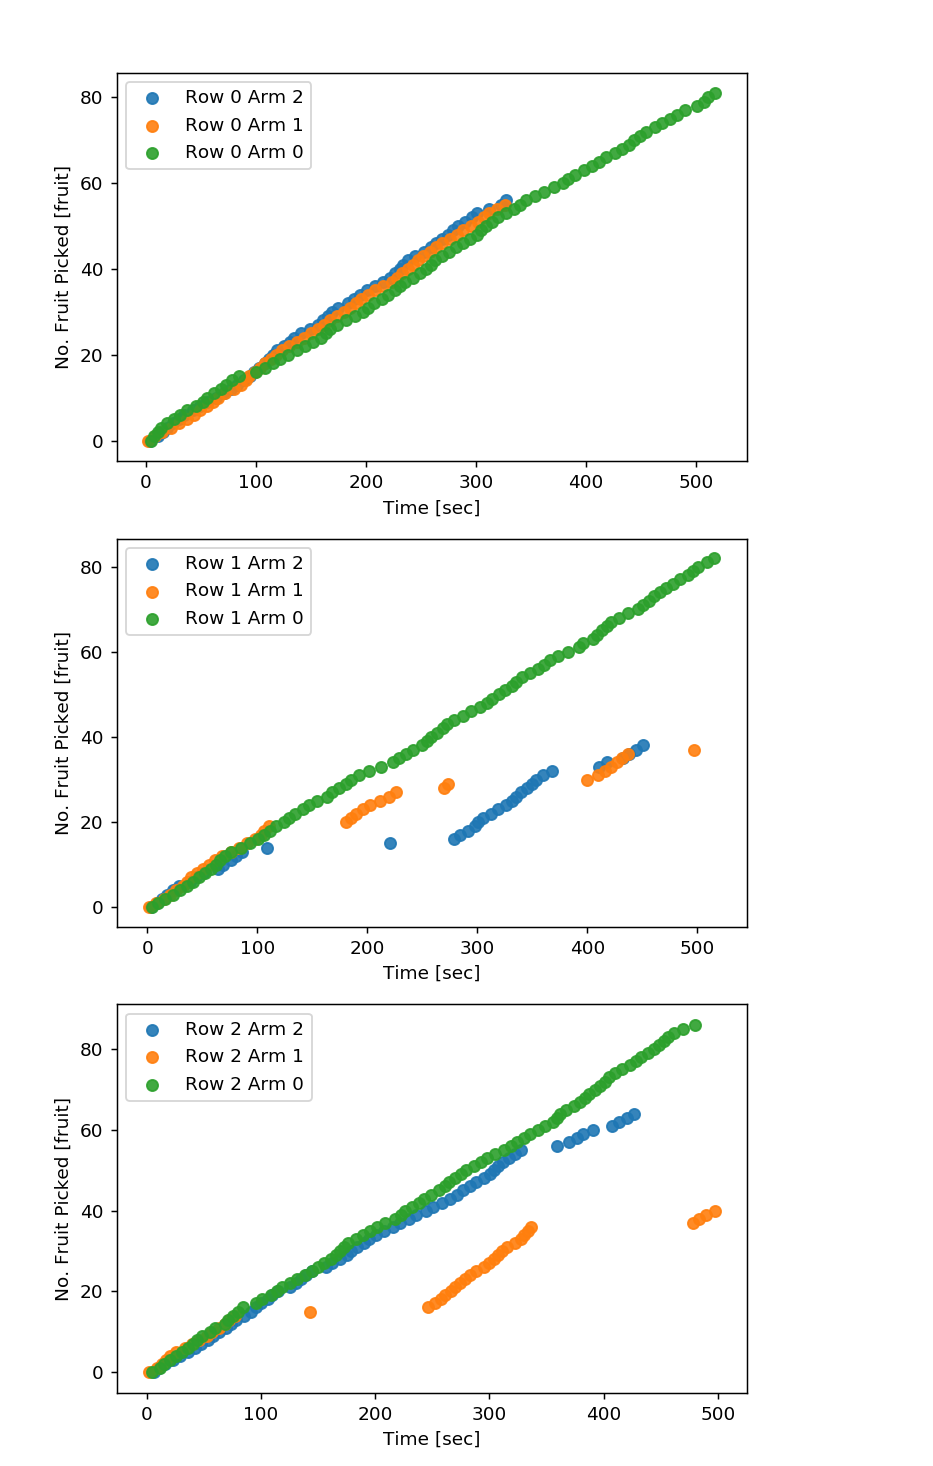

In [16]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [17]:
# analyze the % time each arm is in each state 
idle       = 0.
pickingyz  = 0.
pickingx   = 0.
grabbing   = 0.
retracting = 0.
unloading  = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

# obtain the state for each arm
for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
       
    state_step += 1
        
idle_arm   = 0.
pickyz_arm = 0.
pickx_arm  = 0.
grab_arm   = 0.
retr_arm   = 0.
unlo_arm   = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = []


# for each arm take the state obtained using state_data, determine the state at each time point for each arm 
for i in range(tot_num_arms):
    for x in state_data[i]:
        if x == 0:
            idle_arm   += 1
        elif x == 1:
            pickyz_arm += 1
        elif x == 2:
            pickx_arm  += 1
        elif x == 3:
            grab_arm   += 1
        elif x == 4:
            retr_arm   += 1
        elif x == 5:
            unlo_arm   += 1
    
    # add them all together so that percentages can be calculated
    total = idle_arm + pickyz_arm + pickx_arm + grab_arm + retr_arm + unlo_arm
    
    # get the total amount of time all arms spent in each state
    idle       += idle_arm
    pickingyz  += pickyz_arm
    pickingx   += pickx_arm
    grabbing   += grab_arm
    retracting += retr_arm
    unloading  += unlo_arm
    
    # append the current arm's data to the plotting list
    idle_plot.append(idle_arm)
    pickyz_plot.append(pickyz_arm)
    pickx_plot.append(pickx_arm)
    grab_plot.append(grab_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    # used to detemine which row corresponds to the specific arm
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    # reset for the next run
    idle_arm   = 0.
    pickyz_arm = 0.
    pickx_arm  = 0.
    grab_arm   = 0.
    retr_arm   = 0.
    unlo_arm   = 0.


In [18]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


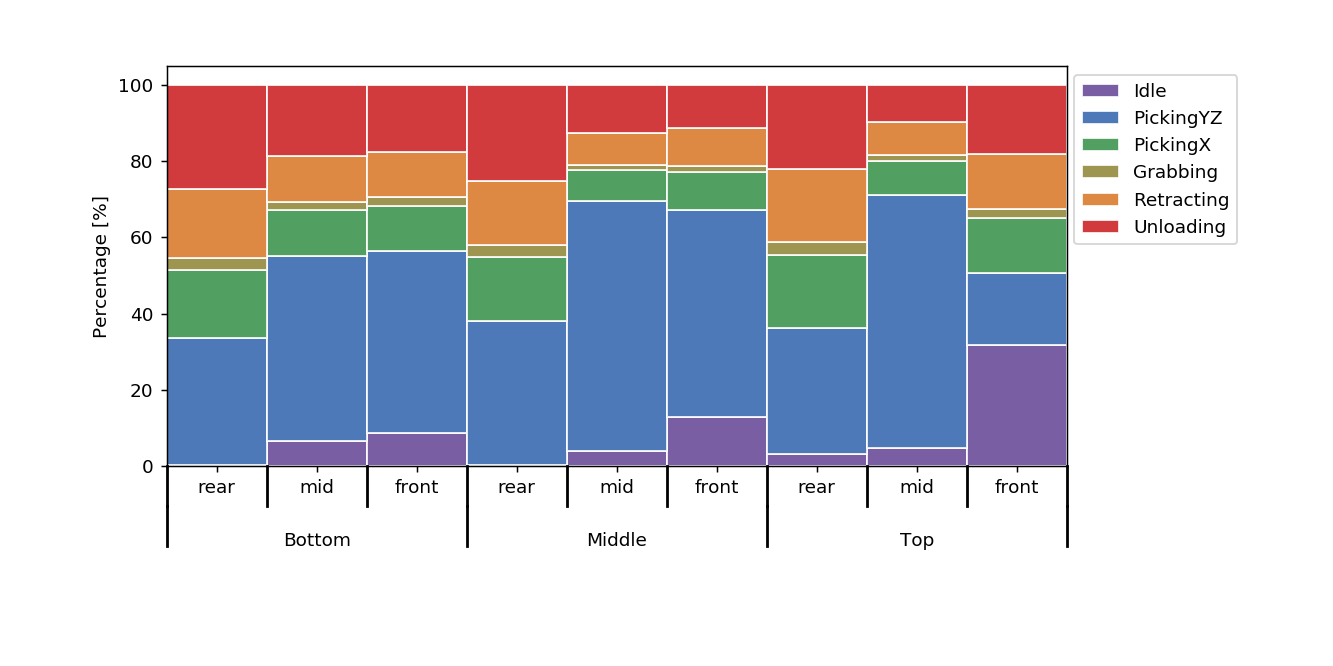

In [19]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
#         'Middle Bt':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
#         'Middle Top':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#6B4C9A',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#396AB1', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3E9651', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#948B3D', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#DA7C30', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#CC2529', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [22]:
# total values 
idle_all = idle*dt
pickyz_all = pickingyz*dt
pickx_all = pickingx*dt
grab_all = grabbing*dt
retract_all = retracting*dt
unload_all = unloading*dt

# print("total time spent idle for all arms:", idle_all, "sec")
# print("total time spent picking in yz axis for all arms:", pickyz_all, "sec")
# print("total time spent picking in x axis for all arms:", pickx_all, "sec")
# print("total time spent grabbing fruit for all arms:", grab_all, "sec")
# print("total time spent retracting for all arms:", retract_all, "sec")
# print("total time spent unloading for all arms:", unload_all, "sec")

total_time = (idle_all + pickyz_all + pickx_all + grab_all + retract_all + unload_all) # / (num_arms*num_row_arms)

# print("total time all arms:", total_time, "sec") 
# print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle    = (idle_all / total_time) * 100
percent_pickyz  = (pickyz_all / total_time) * 100
percent_pickx   = (pickx_all / total_time) * 100
percent_grab    = (grab_all / total_time) * 100
percent_retract = (retract_all / total_time) * 100
percent_unload  = (unload_all / total_time) * 100

print("For all arms:")
print("Total percent time idle:             {0:.2f}".format(percent_idle), "%")
print("Total percent picking fruit          {0:.2f}".format(percent_pickyz+percent_pickx+percent_grab), "%")
print("---------------------------------------------")
print("Picking fruit is broken up into:")
print("Total percent time picking in y, z:  {0:.2f}".format(percent_pickyz), "%")
print("Total percent time picking in x:      {0:.2f}".format(percent_pickx), "%")
print("Total percent time grabbing fruit     {0:.2f}".format(percent_grab), "%")
print("---------------------------------------------")
print("Total percent time retracting        {0:.2f}".format(percent_retract), "%")
print("Total percent time unloading         {0:.2f}".format(percent_unload), "%")


For all arms:
Total percent time idle:             7.98 %
Total percent picking fruit          60.70 %
---------------------------------------------
Picking fruit is broken up into:
Total percent time picking in y, z:  45.14 %
Total percent time picking in x:      13.22 %
Total percent time grabbing fruit     2.34 %
---------------------------------------------
Total percent time retracting        13.23 %
Total percent time unloading         18.08 %


In [20]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals: {0:.2f}".format(percent_reached), "%")
        print("")

For arm 0 row 0
Number of goals given: 91 number of goals reached: 82
Percent reached goals: 90.11 %

For arm 1 row 0
Number of goals given: 89 number of goals reached: 56
Percent reached goals: 62.92 %

For arm 2 row 0
Number of goals given: 87 number of goals reached: 57
Percent reached goals: 65.52 %

For arm 0 row 1
Number of goals given: 109 number of goals reached: 83
Percent reached goals: 76.15 %

For arm 1 row 1
Number of goals given: 114 number of goals reached: 38
Percent reached goals: 33.33 %

For arm 2 row 1
Number of goals given: 108 number of goals reached: 39
Percent reached goals: 36.11 %

For arm 0 row 2
Number of goals given: 91 number of goals reached: 87
Percent reached goals: 95.60 %

For arm 1 row 2
Number of goals given: 83 number of goals reached: 41
Percent reached goals: 49.40 %

For arm 2 row 2
Number of goals given: 78 number of goals reached: 65
Percent reached goals: 83.33 %



num runs 52001


<IPython.core.display.Javascript object>


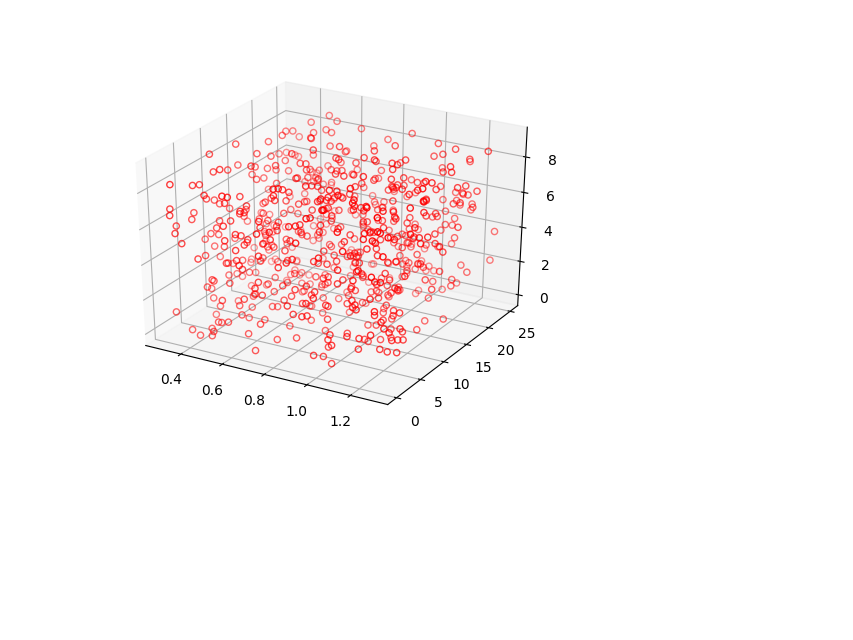

NameError: name 'ax' is not defined

In [21]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(fruit_row_ed-3, fruit_row_tk+3)
        ax.set_zlim(fruit_row_bt-3, fruit_row_tp+3)
        
        ax.set_ylim(fruit_row_st-3, fruit_row_end+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()



In [29]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        
# should plot the three different groups to see where they are
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

per = 100* (miss+sched) / (miss+sched+pick)

print("Percent missed fruit: {0:.2f}".format(per), "%")

Total missed fruit: 45
Total scheduled, but not picked fruit: 85
Total picked fruit: 545

They add up to: 675
Total unpicked fruit: 130
Percent missed fruit: 19.26 %
